#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning
# Simone Trevisan 1238612

# DQN - CartPole: visual input

## Environment initialization

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory
import torchvision.transforms as T
from PIL import Image

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,715 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://develope

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Experience replay (Replay Memory)

Replay memory to store old experiences:

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Short memory to store last four states:

In [ ]:
class ShortMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        for _ in range(capacity):
          self.memory.append(torch.zeros((1,80,80)))

    def push(self, state):
      self.memory.append(state) # Add the last state to the queue

    def get(self):
      if self.memory[3] is None:
        return None
      else:
        ch4_im = torch.stack((torch.squeeze(self.memory[3]),
                            torch.squeeze(self.memory[2]),
                            torch.squeeze(self.memory[1]),
                            torch.squeeze(self.memory[0])))
        return ch4_im

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policy network

### Network definition

Input sample:

torch.Size([1, 160, 240])


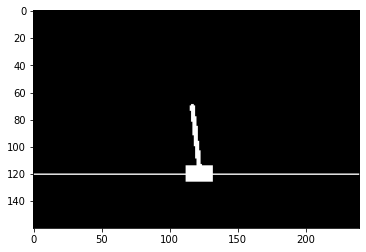

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
a = env.reset()
for _ in range(7):
  env.step(1)

fig = env.render(mode='rgb_array')
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),         
                    T.Resize((160,240), interpolation=Image.CUBIC),
                    T.ToTensor(),
                    T.Normalize(mean=[0.5],
                            std=[0.225]),
                    lambda x: x<1,
                    lambda x: x.float(),
                    T.Normalize(mean=[0.5],
                            std=[0.225])])
fig = resize(fig)
print(fig.shape)
plt.imshow(np.squeeze(fig), 'gray')
env.close()

In [ ]:
class DQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(

                self.depthwise_separable_block(channels,64,4,2,0),

                self.depthwise_separable_block(64,64,4,2,0),
  
                self.depthwise_separable_block(64,64,3,1,0),

                )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=action_space_dim)
        )

    def depthwise_separable_block(self, nin, nout, kernel,strd, pad):
        return nn.Sequential(
            nn.Conv2d(nin, 2*nin, kernel_size=kernel, stride=strd, padding=pad, groups=2),
            nn.BatchNorm2d(2*nin),
            nn.ReLU(),
            nn.Conv2d(2*nin, nout, kernel_size=1),
            nn.BatchNorm2d(nout),
            nn.ReLU()
        )

    def forward(self, x):
        return self.linear(self.conv(x))

In [ ]:
dqn = DQN(4,2)

from torchsummary import summary
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dqn.to(device)
summary(dqn, input_size=(4,80,80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 39, 39]             264
       BatchNorm2d-2            [-1, 8, 39, 39]              16
              ReLU-3            [-1, 8, 39, 39]               0
            Conv2d-4           [-1, 64, 39, 39]             576
       BatchNorm2d-5           [-1, 64, 39, 39]             128
              ReLU-6           [-1, 64, 39, 39]               0
            Conv2d-7          [-1, 128, 18, 18]          65,664
       BatchNorm2d-8          [-1, 128, 18, 18]             256
              ReLU-9          [-1, 128, 18, 18]               0
           Conv2d-10           [-1, 64, 18, 18]           8,256
      BatchNorm2d-11           [-1, 64, 18, 18]             128
             ReLU-12           [-1, 64, 18, 18]               0
           Conv2d-13          [-1, 128, 16, 16]          36,992
      BatchNorm2d-14          [-1, 128,

### Exploration Policy

#### Epsilon-greedy policy


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.cpu().argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

#### Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)
        #print(net_out)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.cpu()[0] / temperature, dim=0).numpy()
    #print(softmax_out)            
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    #print(len(all_possible_actions))
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

#### Exploration profile

Text(0, 0.5, 'Exploration profile')

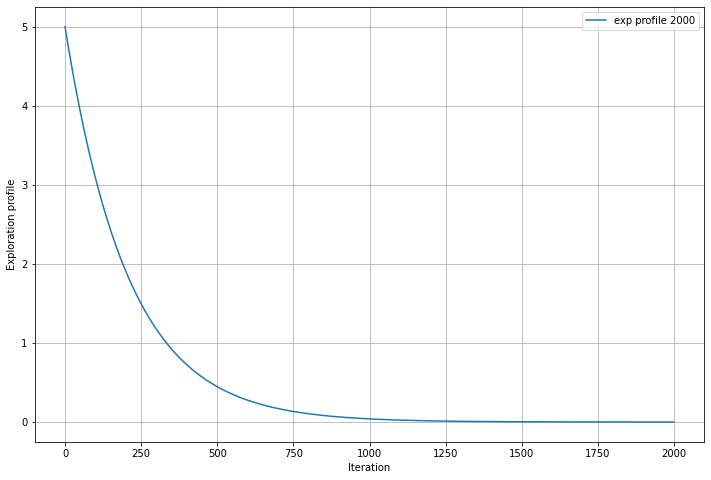

In [ ]:
### Define exp exploration profile
initial_value = 5
num_iterations = 2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exp_profile_m = [initial_value * (exp_decay ** i) for i in range(num_iterations)]


### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(exp_profile_m, label='exp profile 2000')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')

## Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Network update

### Initialization

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 50000   # Replay memory capacity
lr = 1e-4   # Optimizer learning rate
target_net_update_steps = 2   # Number of episodes to wait before updating the target network
batch_size = 64   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_mem = ReplayMemory(replay_memory_capacity)  
short_mem = ShortMemory(4)

### Initialize the policy network
policy_net = DQN(4, 2)
policy_net.to(device)
### Initialize the target network with the same weights of the policy network
target_net = DQN(4, 2)
target_net.to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

### Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states = []
    for i in range(len(batch)):
      states.append(batch[i][0])
    states = torch.stack(states)
    states = states.squeeze()
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = []
    non_final_mask = []
    for i in range(len(batch)):
        if batch[i][2] is None:
          non_final_mask.append(False)
        else:
          non_final_next_states.append(batch[i][2])
          non_final_mask.append(True)
    non_final_next_states = torch.stack(non_final_next_states).to(device)
    non_final_mask = torch.tensor(non_final_mask,dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    states = states.to(device)
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.cpu().gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards.cpu() + (next_state_max_q_values.cpu() * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 5 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 5)
    optimizer.step()

In [ ]:
env.close()

### Training loop

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Updating target network...
EPISODE: 1 - FINAL SCORE: 10 - Temperature: 0.25
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.2487958309579979
Updating target network...


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


EPISODE: 3 - FINAL SCORE: 8 - Temperature: 0.24759746200832264
EPISODE: 4 - FINAL SCORE: 12 - Temperature: 0.24640486521380783
Updating target network...
EPISODE: 5 - FINAL SCORE: 8 - Temperature: 0.24521801277185112
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.24403687701376658
Updating target network...
EPISODE: 7 - FINAL SCORE: 14 - Temperature: 0.24286143040413916
EPISODE: 8 - FINAL SCORE: 14 - Temperature: 0.24169164554018313
Updating target network...
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.240527495151103
EPISODE: 10 - FINAL SCORE: 14 - Temperature: 0.23936895209745793
Updating target network...
EPISODE: 11 - FINAL SCORE: 8 - Temperature: 0.23821598937052896
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.23706858009168935
Updating target network...
EPISODE: 13 - FINAL SCORE: 8 - Temperature: 0.23592669751177814
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.23479031501047626
Updating target network...
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 0.23365940609568608
EPISOD

Text(0, 0.5, 'Scores')

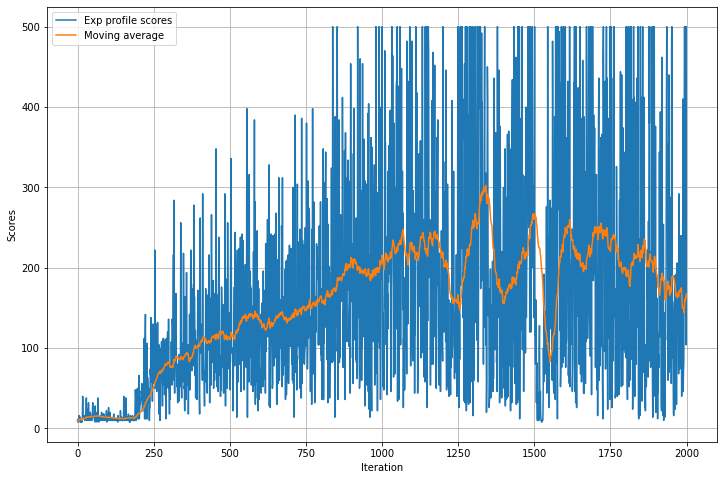

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
mov_avg = []
wnd = deque(maxlen=50)
scores_l = []
for episode_num, tau in enumerate(tqdm(exp_profile_m)):

    # Reset the environment and get the initial state
    num_states = env.reset()
    short_mem = ShortMemory(4)
    fig = env.render(mode='rgb_array')
    state = resize(fig)
    center = num_states[0]*25+120
    state = T.functional.crop(state,top=60,left=int(center-40),height=80,width=80)
    short_mem.push(state)
    short_mem.push(state)
    last4_states = short_mem.get()
    last4_states = last4_states.unsqueeze(0)

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:
      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, last4_states, epsilon=tau/20)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      if next_state is not None:
        fig = env.render(mode='rgb_array')
        next_state = resize(fig)
        center = num_states[0]*25+120
        next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
        short_mem.push(next_state)
      score +=1

      next_state, reward, done, info = env.step(action)
      # Update the final score (+1 for each step)
      score += 1

      if done: # if the pole has fallen down
        next_state = None
      
      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(num_states[0]) 

      num_states = next_state
      if next_state is not None:
        fig = env.render(mode='rgb_array')
        next_state = resize(fig)
        center = num_states[0]*25+120
        next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
        short_mem.push(next_state)
        next4_states = short_mem.get()
        replay_mem.push(last4_states, action, next4_states, reward)
        next4_states = next4_states.unsqueeze(0)
      else:
        replay_mem.push(last4_states, action, next_state, reward)
      
      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Set the current state for the next iteration
      last4_states = next4_states

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    scores_l.append(score)
    wnd.append(score)
    mov_avg.append(np.mean(wnd))
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau/20}") # Print the final score

env.close()

plt.figure(figsize=(12,8))
plt.plot(scores_l, label='Exp profile scores')
plt.plot(mov_avg, label='Moving average')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(3) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
scoress = []
# Let's try for a total of 100 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    num_states = env.reset()
    short_mem = ShortMemory(4)
    fig = env.render(mode='rgb_array')
    state = resize(fig)
    center = num_states[0]*25+120
    state = T.functional.crop(state,top=60,left=int(center-40),height=80,width=80)
    short_mem.push(state)
    last4_states = short_mem.get()
    last4_states = last4_states.unsqueeze(0)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, last4_states, epsilon=0)
      #print(action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      fig = env.render(mode='rgb_array')
      num_states = next_state
      next_state = resize(fig)
      center = num_states[0]*25+120
      next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
      short_mem.push(next_state)
      

      next4_states = short_mem.get()
      next4_states = next4_states.unsqueeze(0)
      # Set the current state for the next iteration
      last4_states = next4_states
      # Check if the episode ended (the pole fell down)
    # Print the final score
    #print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scoress.append(score)
env.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,
         0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

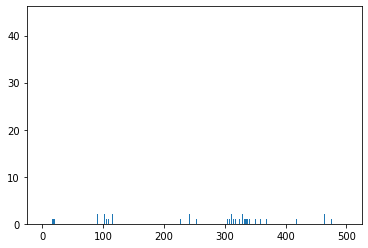

In [ ]:
#plt.bar(range(100),scoress)
plt.hist(scoress,bins = range(0,501,1))

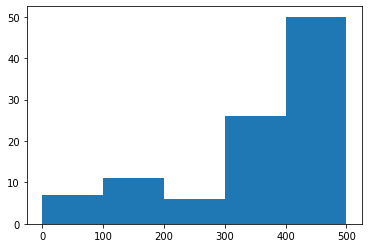

In [ ]:
#plt.bar(range(100),scoress)
_=plt.hist(scoress,bins = range(0,600,100))

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
scoress2 = []
# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    num_states = env.reset()
    short_mem = ShortMemory(4)
    fig = env.render(mode='rgb_array')
    state = resize(fig)
    center = num_states[0]*25+120
    state = T.functional.crop(state,top=60,left=int(center-40),height=80,width=80)
    short_mem.push(state)
    last4_states = short_mem.get()
    last4_states = last4_states.unsqueeze(0)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, last4_states, epsilon=0)
      #print(action)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      fig = env.render(mode='rgb_array')
      num_states = next_state
      next_state = resize(fig)
      center = num_states[0]*25+120
      next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
      short_mem.push(next_state)
      if not done:
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        fig = env.render(mode='rgb_array')
        num_states = next_state
        next_state = resize(fig)
        center = num_states[0]*25+120
        next_state = T.functional.crop(next_state,top=60,left=int(center-40),height=80,width=80)
        short_mem.push(next_state)

      next4_states = short_mem.get()
      next4_states = next4_states.unsqueeze(0)
      #next_state = next_state.unsqueeze(0)
      # Set the current state for the next iteration
      last4_states = next4_states
      # Check if the episode ended (the pole fell down)
    # Print the final score
    #print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scoress2.append(score)
env.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 2., 0., 0.,
        1., 2., 2., 2., 2., 1., 2., 0., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 3., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 2., 1., 0., 0.,
        0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 1., 1., 0., 0., 1., 3., 1.,
        0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

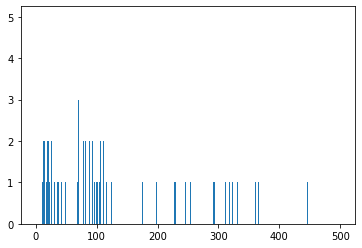

In [ ]:
#plt.bar(range(100),scoress)
plt.hist(scoress2,bins = range(0,501,1))

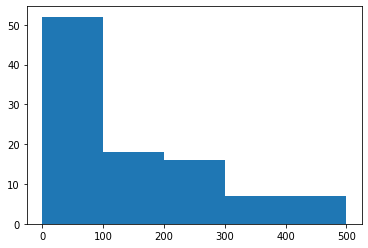

In [ ]:
#plt.bar(range(100),scoress)
_ = plt.hist(scoress2,bins = range(0,600,100))

In [ ]:
torch.save(policy_net.state_dict(), 'policy_params_3.pth')
torch.save(target_net.state_dict(), 'target_params_3.pth')